## Bikes Linear Regression project

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
sns.set_style("whitegrid")

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
train = pd.read_csv('../data/train.csv')

In [4]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Data Exploration

In [6]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<AxesSubplot:>

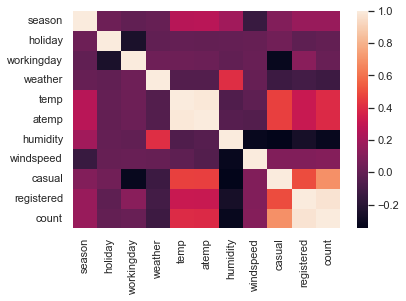

In [7]:
sns.heatmap(train.corr() )

#random forest important features

#### 1. Workingday Casual/Registered Trends
Ratio Casual/Registered is different on working days.
Divide casual and registered? Look for interactions? Some variables might be useful depending on if it's a  working days or might predict different kinds of users differently.

In [8]:
train_wd = train.groupby('workingday')[['casual','registered','count']].mean()
train_wd

,casual,registered,count
workingday,,,
0,59.308290,129.198330,188.506621
1,25.107663,167.904209,193.011873


In [9]:
train_wd = train_wd.reset_index()
train_wd 

,workingday,casual,registered,count
0,0,59.308290,129.198330,188.506621
1,1,25.107663,167.904209,193.011873


Split this information in regard to casuals and registered

In [10]:
#sns.barplot(data=train, x='workingday' , hue=')

In [11]:
train.groupby('season')['count'].mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: count, dtype: float64

#### 2. Holiday

Same as Working Day, the proportion of casual(registered varies. More casuals on holydays.

In [12]:
train.groupby('holiday')[['casual', 'registered','count']].mean()

,casual,registered,count
holiday,,,
0,35.646714,156.094941,191.741655
1,48.781350,137.096463,185.877814


#### 3. Weather
Linear dependence? Specially on non-working days

In [13]:
train.groupby('weather')['count'].mean()

weather
1    205.236791
2    178.955540
3    118.846333
4    164.000000
Name: count, dtype: float64

#### 4. Temperature
Linear specially on non-working days?
Interaction workingday-atemp ?

<AxesSubplot:xlabel='temp', ylabel='count'>

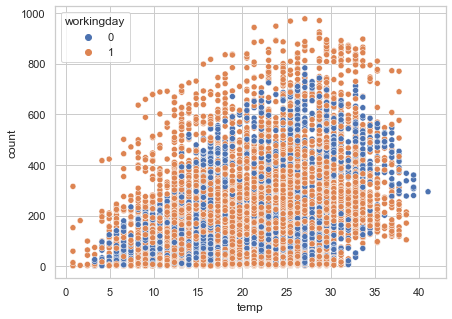

In [15]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=train, x='temp', y='count', hue='workingday')

<AxesSubplot:xlabel='atemp', ylabel='count'>

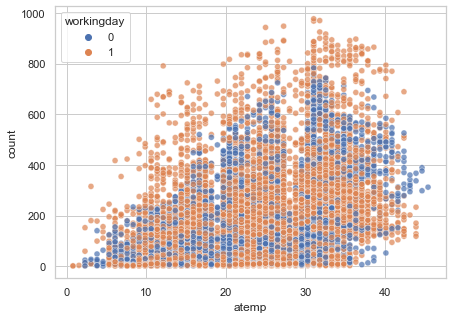

In [16]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=train, x='atemp', y='count', hue='workingday', alpha=0.7)

<AxesSubplot:xlabel='atemp', ylabel='casual'>

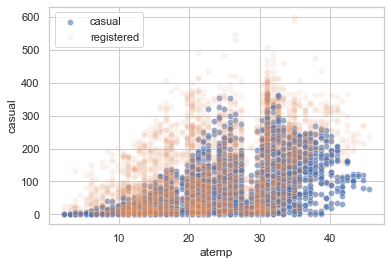

In [17]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=train[train['workingday']==0], x='atemp', y='casual', alpha=0.6, label='casual'),
sns.scatterplot(data=train[train['workingday']==0], x='atemp', y='registered',alpha=0.1, label='registered')

<AxesSubplot:xlabel='atemp', ylabel='casual'>

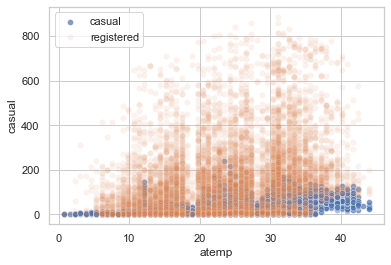

In [18]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=train[train['workingday']==1], x='atemp', y='casual', alpha=0.7, label='casual'),
sns.scatterplot(data=train[train['workingday']==1], x='atemp', y='registered',alpha=0.1, label='registered')

#### 5. Humidity

<AxesSubplot:xlabel='humidity', ylabel='count'>

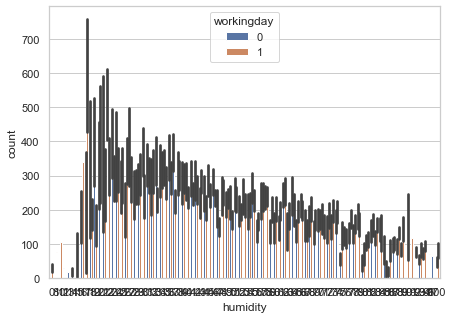

In [19]:
plt.figure(figsize=(7,5))
sns.barplot(data=train, x='humidity', y='count', hue='workingday' )

Because of the high score in the single Linear Regression, let's took a better look.
Binning, groupby and then histogram.

#### 6. Windspeed

<AxesSubplot:xlabel='windspeed', ylabel='count'>

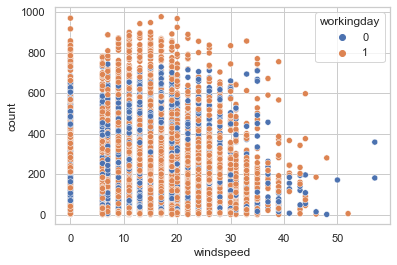

In [20]:
sns.scatterplot(data=train, x='windspeed', y='count', hue='workingday' )

#### 7. Time Features

Convert to data time series with data time objects (timestamps):

In [21]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [22]:
train['hour'] = train['datetime'].dt.hour
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1


Hour of the Day
- Strong dependence
- Try with polynom?
- Split base count from rush hour?
- Translate x-axis?

In [23]:
train_hour_count = train.groupby('hour')['count'].mean()
train_hour_reg = train.groupby('hour')['registered'].mean()
train_hour_casual = train.groupby('hour')['casual'].mean()

In [24]:
train_hour_count

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: count, dtype: float64

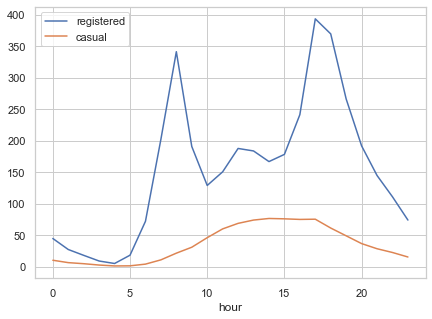

In [25]:
train_hour_reg.plot(figsize=(7, 5))
train_hour_casual.plot(figsize=(7,5))
plt.legend()

<AxesSubplot:xlabel='hour', ylabel='registered'>

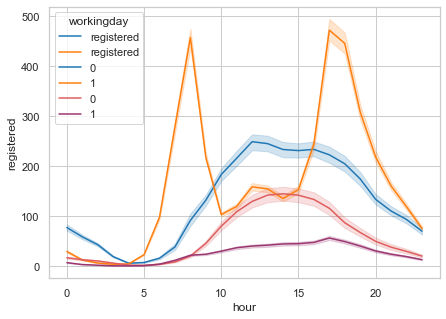

In [26]:
plt.figure(figsize=(7,5))
sns.lineplot(data=train, x='hour', y='registered', hue='workingday', palette='tab10', label='registered')
sns.lineplot(data=train, x='hour', y='casual', hue='workingday', palette='flare')

In [27]:
train[train['workingday']==1].groupby('hour')['registered'].mean()

hour
0      29.558065
1      12.556634
2       6.334426
3       4.013841
4       4.629630
5      23.241935
6      98.296774
7     278.748387
8     457.900000
9     218.248387
10    103.387097
11    119.919355
12    158.938907
13    154.945338
14    135.684887
15    153.446945
16    244.720257
17    472.700965
18    446.070740
19    308.826367
20    218.771704
21    160.765273
22    119.077170
23     75.813505
Name: registered, dtype: float64

Hour and Season

In [29]:
seasons = [ '','winter', 'spring', 'summer', 'fall']

season -  1 = winter, 2 = spring, 3 = summer, 4 = fall 

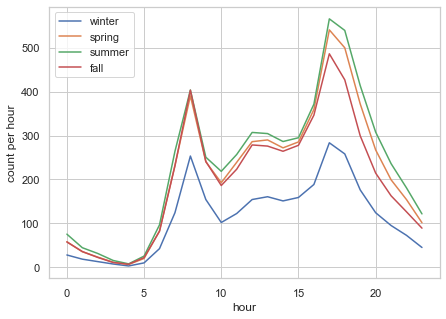

In [28]:
plt.figure(figsize=(7,5))
plt.ylabel('count per hour')
for i in range (1,5) :
    train_si = train[train['season']==i]
    train_count_h_si = train_si.groupby('hour')['count'].mean()
    sns.lineplot(data=train_count_h_si, label=seasons[i]) #label='Season {}'.format(i)
    
                    

The Month of the year<br>
- Strong dependence
- Try with polynom? Degree = 3 suits well
- Baseline predictor mean of each month?

In [33]:
train['month'] = train['datetime'].dt.month
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1


In [34]:
train_count_mmax = train.groupby('month')[['casual','registered','count']].max()
train_count_mmin = train.groupby('month')[['casual','registered','count']].min()
train_count_mmax, train_count_mmin

(       casual  registered  count
 month                           
 1         156         497    512
 2         229         522    539
 3         367         681    801
 4         355         677    822
 5         361         770    873
 6         297         782    869
 7         269         790    872
 8         289         786    897
 9         350         886    977
 10        362         857    948
 11        304         694    724
 12        167         737    759,
        casual  registered  count
 month                           
 1           0           0      1
 2           0           0      1
 3           0           0      1
 4           0           0      1
 5           0           1      1
 6           0           1      1
 7           0           1      1
 8           0           0      1
 9           0           0      1
 10          0           1      1
 11          0           1      1
 12          0           1      1)

<AxesSubplot:xlabel='month'>

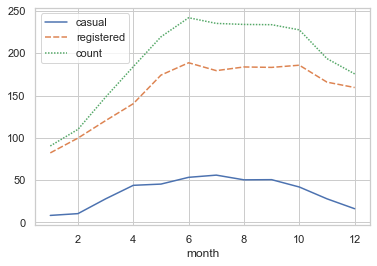

In [35]:
train_count_m = train.groupby('month')[['casual','registered','count']].mean()
sns.lineplot(data=train_count_m )

Rush hour

In [36]:
train['rush_h'] = train['hour']
train['rush_h']

0         0
1         1
2         2
3         3
4         4
         ..
10881    19
10882    20
10883    21
10884    22
10885    23
Name: rush_h, Length: 10886, dtype: int64

Rush Hour is 1 for the hours 8, 17 and 18

In [38]:
for n in range(0,len(train)) :
    if n==8 or n==17 or n==18 :
        train['rush_h'][n] = 1
    else :
        train['rush_h'][n] = 0

C:\Users\PC\AppData\Local\Temp/ipykernel_19872/3962439643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rush_h'][n] = 0
C:\Users\PC\AppData\Local\Temp/ipykernel_19872/3962439643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rush_h'][n] = 1


practicing with dt.day_name() vs .day_name()

In [39]:
train['datetime'].dt.day_name()

0         Saturday
1         Saturday
2         Saturday
3         Saturday
4         Saturday
           ...    
10881    Wednesday
10882    Wednesday
10883    Wednesday
10884    Wednesday
10885    Wednesday
Name: datetime, Length: 10886, dtype: object

In [40]:
train['datetime'][158].day_name() #on 1 timestamp

'Friday'

### Linear Regression

Checking the Nans

In [41]:
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
hour          0
month         0
rush_h        0
dtype: int64

#### Linear Regression of the single un-engineered features:

In [42]:
features = train.drop(['casual','registered','count'],axis=1).columns[1:]
for feature in features :    
    X = train [[feature]]
    y = train['count']
    
    m = LinearRegression()
    m.fit(X,y)
    m.score(X,y)

    print ('Feature:',feature,'Score: %.3f' % m.score(X,y) )

Feature: season Score: 0.027
Feature: holiday Score: 0.000
Feature: workingday Score: 0.000
Feature: weather Score: 0.017
Feature: temp Score: 0.156
Feature: atemp Score: 0.152
Feature: humidity Score: 0.101
Feature: windspeed Score: 0.010
Feature: hour Score: 0.160
Feature: month Score: 0.028
Feature: rush_h Score: 0.000


- Start with temp and hour and humidity!!!
- temp is better than atemp

#### Polynomial Linear Regression of the single features

In [43]:
features = train.drop(['casual','registered','count'],axis=1).columns[1:]
for feature in features :    
    X = train [[feature]]
    y = train['count']
    
    m = LinearRegression()
    mpol = PolynomialFeatures(degree=2, include_bias=False)
    
    X_poly = mpol.fit_transform(X)
    
    m.fit(X_poly,y)
    m.score(X_poly,y)

    print ('Feature:',feature,'Score: %.3f' % m.score(X_poly,y) )

Feature: season Score: 0.061
Feature: holiday Score: 0.000
Feature: workingday Score: 0.000
Feature: weather Score: 0.018
Feature: temp Score: 0.156
Feature: atemp Score: 0.153
Feature: humidity Score: 0.102
Feature: windspeed Score: 0.013
Feature: hour Score: 0.306
Feature: month Score: 0.071
Feature: rush_h Score: 0.000


Dramatic improvement on hour, degree n=3 gets a score of 0.378
Improvement on season and month, but they're co-dependent

### Selecting features and target:
#### First feature: temp

temp is better than atemp<br>
Interaction with workingday?<br>
Possible: baseline predict the mean of all observations

In [44]:
X = train[['temp']]
y = train['count']

In [45]:
X.shape, y.shape

((10886, 1), (10886,))

In [46]:
m = LinearRegression()

In [47]:
m.fit(X, y)

LinearRegression()

In [48]:
y_pred = m.predict(X)

In [49]:
round(m.score(X, y),5) #coefficient of determination R2

0.15559

Baseline: count average

In [50]:
y_mean = [y.mean()]*len(y)
len(y_mean)

10886

In [51]:
m.score(X, y_mean)

0.0

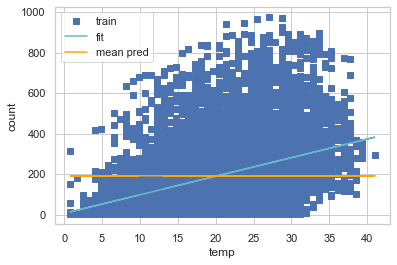

In [52]:
plt.plot(X, y,'bs', label="train")
plt.plot(X, y_pred, 'c', label="fit")

plt.plot(X, [y.mean()]*len(y), 'orange', label="mean pred")

plt.xlabel('temp')
plt.ylabel('count')

plt.legend()

In [53]:
# The mean squared error 
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# The mean absolute error 
print('Mean absolute error: %.2f'
      % mean_absolute_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction f
print('Coefficient of determination: %.5f'
      % r2_score(y, y_pred))

Mean squared error: 27705.22
Mean absolute error: 126.68
Coefficient of determination: 0.15559


add features, understand score = R2, crossvalidation

#### temp and workingday

In [54]:
X = train[['temp','workingday']]
y = train['count']

In [55]:
m = LinearRegression().fit(X,y)
X
m.score(X,y)

0.15559372921919856

#### New Feature Month

Baseline: the mean of the month as calculated before

In [56]:
#train['count'].groupby('month').mean()

In [57]:
X = train[['month']]
y = train['count']

In [58]:
X.shape, y.shape

((10886, 1), (10886,))

In [59]:
m = LinearRegression()

In [60]:
m.fit(X, y)

LinearRegression()

In [61]:
y_pred = m.predict(X)

In [62]:
round(m.score(X, y),4) #coefficient of determination R2

0.0278

In [63]:
m.intercept_, m.coef_

(134.34461887163508, array([8.77551983]))

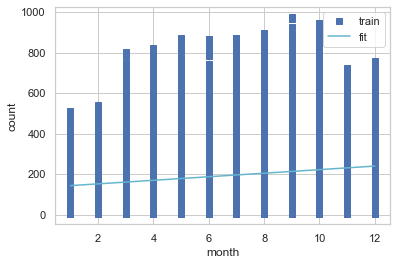

In [64]:
plt.plot(X, y,'bs', label="train")
plt.plot(X, y_pred, 'c', label="fit")
plt.xlabel('month')
plt.ylabel('count')

plt.legend()

In [65]:
# The mean squared error 
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# The mean absolute error 
print('Mean absolute error: %.2f'
      % mean_absolute_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction f
print('Coefficient of determination: %.4f'
      % r2_score(y, y_pred))

Mean squared error: 31896.76
Mean absolute error: 139.44
Coefficient of determination: 0.0278


Now let's try with parabol and then  with a cubic polynom fit

In [66]:
X = train[['month']]
y = train['count']

In [67]:
mpol = PolynomialFeatures(degree=2, include_bias=True)

In [68]:
X_with_poly = mpol.fit_transform(X)

In [69]:
m = LinearRegression()

In [70]:
m.fit(X_with_poly, y) #also m = LinearRegression().fit(X_with_poly, y)

LinearRegression()

In [71]:
y_pred = m.predict(X_with_poly)
y_pred

array([ 76.54523356,  76.54523356,  76.54523356, ..., 174.062461  ,
       174.062461  , 174.062461  ])

In [72]:
round(m.score(X_with_poly, y),4) #coefficient of determination R2

0.0715

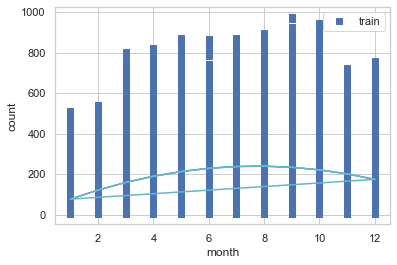

In [73]:
plt.clf()
plt.plot(X, y,'bs', label="train")
plt.plot(X, y_pred, 'c')
plt.xlabel('month')
plt.ylabel('count')

plt.legend()

#### New Feature Hour

One approach: try with a high degree polynomium
Another approach: separate the rush hour from the rest

In [74]:
X = train[['hour']]
y = train['count']

In [75]:
X.shape, y.shape

((10886, 1), (10886,))

In [76]:
m = LinearRegression()

In [77]:
m.fit(X, y)

LinearRegression()

In [78]:
y_pred = m.predict(X)

In [79]:
round(m.score(X, y),4) #coefficient of determination R2

0.1605

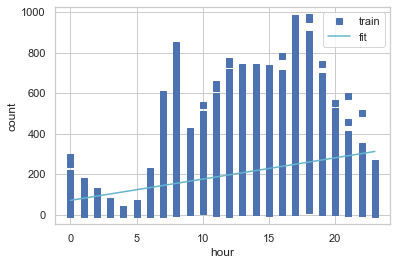

In [80]:
plt.plot(X, y,'bs', label="train")
plt.plot(X, y_pred, 'c', label="fit")
plt.xlabel('hour')
plt.ylabel('count')


plt.legend()

In [81]:
# The mean squared error 
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# The mean absolute error 
print('Mean absolute error: %.2f'
      % mean_absolute_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction f
print('Coefficient of determination: %.4f'
      % r2_score(y, y_pred))

Mean squared error: 27544.86
Mean absolute error: 125.13
Coefficient of determination: 0.1605


Polynomial Approach degree=2

In [82]:
X = train[['hour']]
y = train['count']

In [83]:
mpol = PolynomialFeatures(degree=2, include_bias=False)
mpol.fit(X)
X_with_poly = mpol.transform(X)

m = LinearRegression().fit(X_with_poly, y)

In [84]:
m.score(X_with_poly, y)

0.30582841876934785

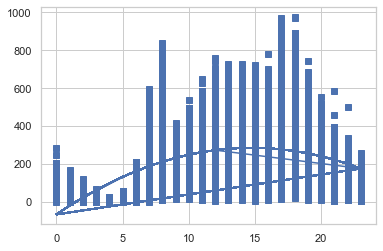

In [85]:
plt.plot(X, y,'bs', label="train")
plt.plot(X, m.predict(X_with_poly))

Polynomial Approach degree=3

In [86]:
X = train[['hour']]
y = train['count']

In [87]:
mpol = PolynomialFeatures(degree=3, include_bias=False)
mpol.fit(X)
X_with_poly = mpol.transform(X)

m = LinearRegression().fit(X_with_poly, y)

In [88]:
m.score(X_with_poly, y)

0.3780109152299439

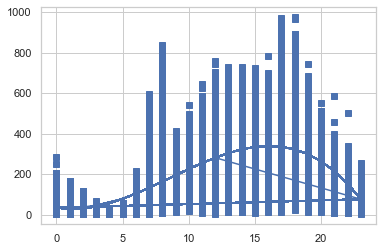

In [89]:
plt.plot(X, y,'bs', label="train")
plt.plot(X, m.predict(X_with_poly))

Humidity

#### Feature Selection with f_regression

In [174]:
X = train[['hour','month','temp','humidity','workingday','holiday','windspeed','rush_h','weather',
          'season']] #left out: datetime, atemp 
y = train['count']

scaler = StandardScaler()
X = scaler.fit_transform(X)

#for i in range(1,11) :
fs = SelectKBest(score_func=f_regression, k=9)
fs.fit(X, y)
X_fs = fs.transform(X)

model = LinearRegression()
model.fit(X_fs, y)
model.score(X_fs, y) 
#plt.plot( model.score(X_fs, y) )

0.33646502061315886

#### Multiple Linear Regression

In [95]:
X = train[['hour','month','temp','humidity','workingday','holiday','windspeed','rush_h','weather',
          'season']] #left out: atemp 
y = train['count']

In [96]:
#rescale, is it necessary here? the score didn't change
scaler = StandardScaler()
X = scaler.fit_transform(X) # only for train (test would have .transform())

mpol = PolynomialFeatures(degree=3, include_bias=True)
X_with_poly = mpol.fit_transform(X)

m = LinearRegression().fit(X_with_poly,y)
m.score(X_with_poly,y)

0.5704722357567464

#### Hyperparameters with GridCV

In [97]:
#instantiate models
m_lr = LinearRegression()
m_ridge = Ridge(alpha=1, random_state=31)
m_lasso = Lasso(alpha=1, random_state=31)
m_elastic_net = ElasticNet(alpha=1, l1_ratio=.5,
                           random_state=31)

In [127]:
mpol.get_params(), m_ridge.get_params(), m_lasso.get_params(), m_elastic_net.get_params()

({'degree': 3, 'include_bias': True, 'interaction_only': False, 'order': 'C'},
 {'alpha': 1,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': None,
  'normalize': False,
  'random_state': 31,
  'solver': 'auto',
  'tol': 0.001},
 {'alpha': 1,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 1000,
  'normalize': False,
  'positive': False,
  'precompute': False,
  'random_state': 31,
  'selection': 'cyclic',
  'tol': 0.0001,
  'warm_start': False},
 {'alpha': 1,
  'copy_X': True,
  'fit_intercept': True,
  'l1_ratio': 0.5,
  'max_iter': 1000,
  'normalize': False,
  'positive': False,
  'precompute': False,
  'random_state': 31,
  'selection': 'cyclic',
  'tol': 0.0001,
  'warm_start': False})

In [138]:
para_grid = { 'degree': [1]}

In [139]:
grid_cv = GridSearchCV(
            estimator=mpol,
            param_grid=para_grid,
            cv=5, #folds
            return_train_score=True,
            scoring= 'neg_mean_squared_error',
            n_jobs=-1, # how many cores, -1 uses all
)

In [140]:
grid_cv.fit(X_with_poly, y) 

C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(
C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=PolynomialFeatures(degree=3), n_jobs=-1,
             param_grid={'degree': [1]}, return_train_score=True,
             scoring='neg_mean_squared_error')

In [99]:
para_grid = { 'alpha': [0.01, 0.1, 1, 10]}

In [100]:
grid_cv = GridSearchCV(
            estimator=m_ridge,
            param_grid=para_grid,
            cv=5, #folds
            return_train_score=True,
            scoring= 'neg_mean_squared_error',
            n_jobs=-1, # how many cores, -1 uses all
)

In [101]:
grid_cv.fit(X_with_poly, y) 

GridSearchCV(cv=5, estimator=Ridge(alpha=1, random_state=31), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, return_train_score=True,
             scoring='neg_mean_squared_error')

In [103]:
grid_cv = GridSearchCV(
            estimator=m_lasso,
            param_grid=para_grid,
            cv=5, #folds
            return_train_score=True,
            scoring= 'neg_mean_squared_error',
            n_jobs=-1, # how many cores, -1 uses all
)

In [104]:
grid_cv.fit(X_with_poly, y) 

GridSearchCV(cv=5, estimator=Lasso(alpha=1, random_state=31), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, return_train_score=True,
             scoring='neg_mean_squared_error')

In [105]:
grid_cv = GridSearchCV(
            estimator=m_elastic_net,
            param_grid=para_grid,
            cv=5, #folds
            return_train_score=True,
            scoring= 'neg_mean_squared_error',
            n_jobs=-1, # how many cores, -1 uses all
)

In [124]:
para_grid = { 'alpha': [0.05, 0.1, 1, 2]}

In [125]:
grid_cv.fit(X_with_poly, y) 

C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58655149.81640318, tolerance: 35717.29136755466
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=ElasticNet(alpha=1, random_state=31), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, return_train_score=True,
             scoring='neg_mean_squared_error')

#### Multiple Linear Regression with Regularisation

In [107]:
X = train[['hour','month','temp', 'humidity', 'workingday', 'holiday','windspeed','weather','rush_h',
          'season','windspeed','weather']] #left out: atemp
y = train['count']

In [115]:
#rescale
scaler = StandardScaler()
X = scaler.fit_transform(X) # only for train (test would have .transform())

#add polynomial feature
mpol = PolynomialFeatures(degree=3, interaction_only=False,include_bias=True)
X_poly = mpol.fit_transform(X)

In [116]:
#instantiate models
m_lr = LinearRegression()
m_ridge = Ridge(alpha=1, random_state=31)
m_lasso = Lasso(alpha=1, random_state=31)
m_elastic_net = ElasticNet(alpha=1, l1_ratio=.5,
                           random_state=31)

In [117]:
#fit the models
m_lr.fit(X_poly, y)
m_ridge.fit(X_poly, y)       # Train the linear model with ridge regularization
m_lasso.fit(X_poly, y)       # Train the linear model with lasso regularization
m_elastic_net.fit(X_poly, y) # Train the linear model with elsticnet regularization

ElasticNet(alpha=1, random_state=31)

In [118]:
#predictions
ypred_poly = m_lr.predict(X_poly)
ypred_ridge = m_ridge.predict(X_poly)
ypred_lasso = m_lasso.predict(X_poly)
ypred_elastic = m_elastic_net.predict(X_poly)

In [119]:
# r^2 and RMSE (root mean-squared error)
m_poly_r2 = m_lr.score(X_poly, y)
m_poly_rmse = np.sqrt(mean_squared_error(y, ypred_poly))

m_ridge_r2 = m_ridge.score(X_poly, y)
m_ridge_rmse = np.sqrt(mean_squared_error(y, ypred_ridge))

m_lasso_r2 = m_lasso.score(X_poly,y)
m_lasso_rmse = np.sqrt(mean_squared_error(y,ypred_lasso))

m_elastic_r2 = m_elastic_net.score(X_poly,y)
m_elastic_rmse = np.sqrt(mean_squared_error(y,ypred_elastic))

In [120]:
#scores
m_poly_r2, m_poly_rmse, m_ridge_r2, m_ridge_rmse, m_lasso_r2, m_lasso_rmse, m_elastic_r2, m_elastic_rmse

(0.5704411415205448,
 118.71796214533225,
 0.5703808795437504,
 118.72628920930126,
 0.5552435362144255,
 120.79980342860388,
 0.4774017065808618,
 130.9450503246224)

In [114]:
#print ( f'linear $R^2 = $ {m_poly_r2:.2f}, RMSE = {m_poly_rmse:.2f}' )


column transformer / pipeline

model selection - cross validation